In [ ]:
# Imports
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Dynamické zjištění kořenového adresáře projektu
try:
    current_script_path = Path(__file__).resolve()
    project_root = current_script_path.parent.parent 
except NameError:
    cwd = Path(os.getcwd())
    if cwd.name == "notebooks" and (cwd.parent / "data").is_dir() and (cwd.parent / "scripts").is_dir():
        project_root = cwd.parent
    elif (cwd / "data").is_dir() and (cwd / "scripts").is_dir():
        project_root = cwd
    else:
        project_root = Path(".").resolve()
        # Toto varování ponecháme pro případ, že by automatická detekce selhala
        print(f"Warning: Could not reliably determine project root. Using CWD: {project_root}")
        print("Please ensure this notebook is run from the project's root directory or the 'notebooks' subdirectory.")

# Důležité výpisy ponecháme
print(f"Project root determined as: {project_root}")
# print(f"Current working directory is: {os.getcwd()}") # Tento výpis můžeme zakomentovat nebo smazat

# Importy vašich modulů z knihovny subcipher
from subcipher.text_utils import clean_text
from subcipher.stats import transition_matrix
from subcipher.alphabet import ALPHABET, IDX2CHAR

print("Subcipher modules imported successfully.")

# --- Definice cest k souborům ---

# Cesta ke korpusu (krakatit.txt)
corpus_file_path = project_root / "data" / "raw" / "corpus" / "krakatit.txt"
print(f"Path to corpus file set to: {corpus_file_path}")

# Cesta pro uložení výsledné referenční matice
output_model_path = project_root / "data" / "model" / "reference_tm.npy"
print(f"Output path for model set to: {output_model_path}")


Project root determined as: c:\Git\DeShiftr
Subcipher modules imported successfully.
Path to corpus file set to: c:\Git\DeShiftr\data\raw\corpus\krakatit.txt
Output path for model set to: c:\Git\DeShiftr\data\model\reference_tm.npy


In [47]:
# corpus_file_path je již definováno v předchozí buňce
print(f"\nAttempting to load corpus from: {corpus_file_path}")

raw_text_corpus = None # Inicializace
fallback_corpus_text = "ABECEDA_JE_ZAKLAD_JAZYKA_A_STATISTIKY_POMAHAJI_S_ANALYZOU_TEXTU_"

if not corpus_file_path.exists() or not corpus_file_path.is_file():
    print(f"Corpus file NOT FOUND or is not a file at: {corpus_file_path}")
    raw_text_corpus = fallback_corpus_text
    print(f"Using fallback demo corpus. Length: {len(raw_text_corpus)} characters.")
else:
    try:
        with open(corpus_file_path, 'r', encoding='utf-8', errors='ignore') as f:
            raw_text_corpus = f.read()
        print(f"Successfully loaded corpus from: {corpus_file_path}")
        print(f"Loaded corpus length: {len(raw_text_corpus)} characters.")
        # print(f"Corpus (first 200 chars): {raw_text_corpus[:200]}") # Výpis ukázky textu zakomentován/smazán
    except PermissionError:
        print(f"PermissionError: Could not read the corpus file at {corpus_file_path}. Check file permissions.")
        raw_text_corpus = fallback_corpus_text 
        print(f"Using fallback demo corpus due to permission error. Length: {len(raw_text_corpus)} characters.")
    except Exception as e:
        print(f"An unexpected error occurred while reading {corpus_file_path}: {e}")
        raw_text_corpus = fallback_corpus_text
        print(f"Using fallback demo corpus due to an unexpected error. Length: {len(raw_text_corpus)} characters.")

# Zkontrolujeme, zda se raw_text_corpus skutečně načetl
if raw_text_corpus is None or len(raw_text_corpus) == len(fallback_corpus_text) : # Kontrola, zda se nepoužil fallback z důvodu chyby
    if raw_text_corpus is None: # Pokud by i fallback selhal (což by neměl)
        print("Critical error: Corpus could not be loaded and no fallback was set.")
        # Zde by bylo vhodné případně ukončit běh nebo vyvolat výjimku, pokud je korpus nezbytný



Attempting to load corpus from: c:\Git\DeShiftr\data\raw\corpus\krakatit.txt
Successfully loaded corpus from: c:\Git\DeShiftr\data\raw\corpus\krakatit.txt
Loaded corpus length: 464446 characters.


In [41]:
# Clean the corpus text
cleaned_corpus = clean_text(raw_text_corpus)
print(f"Cleaned corpus. Length: {len(cleaned_corpus)} characters.")
print(f"Cleaned corpus (first 200 chars): {cleaned_corpus[:200]}")

if not cleaned_corpus:
    raise ValueError("Cleaned corpus is empty. Cannot build model.")


Cleaned corpus. Length: 361005 characters.
Cleaned corpus (first 200 chars): KARELCAPEKKRAKATITZNENITOHOTOTEXTUVYCHAZIZDILAKRAKATITTAKJAKBYLOVYDANOVCESKOSLOVENSKEMSPISOVATELIVROCECAPEKKARELTOVARNANAABSOLUTNOKRAKATITVYDTOVARNYNAABSOLUTNOVYDKRAKATITUPRAHACESKOSLOVENSKYSPISOVATEL


In [42]:
# Build the transition matrix
tm_ref = transition_matrix(cleaned_corpus)

print(f"Transition matrix built. Shape: {tm_ref.shape}")
print(f"Sum of all elements in matrix (should be close to 1.0): {np.sum(tm_ref)}")

DEBUG transition_matrix: Max count in matrix AFTER raw counting: 6992.0
DEBUG transition_matrix: Sum of raw counts (approx, before smoothing zeros): 361004.0
DEBUG transition_matrix: Max value in matrix AFTER pseudocounts: 6992.0
DEBUG transition_matrix: Sum of matrix AFTER pseudocounts: 361164.0
DEBUG transition_matrix: Total sum used for normalization: 361164.0
DEBUG transition_matrix: Max probability in matrix AFTER normalization: 0.01935962609783921
DEBUG transition_matrix: Sum of matrix AFTER normalization: 1.0
Transition matrix built. Shape: (27, 27)
Sum of all elements in matrix (should be close to 1.0): 1.0


In [43]:
# Inspect the matrix (optional)
print("\nSample of the transition matrix (first 5x5 elements):")
print(tm_ref[:5, :5])

# You can also find the most probable bigrams for a few characters
from subcipher.alphabet import ALPHABET, IDX2CHAR
print("\nMost probable characters following 'A':")
if 'A' in ALPHABET:
    a_index = ALPHABET.find('A')
    if a_index != -1 and a_index < tm_ref.shape[0]:
        top_indices = np.argsort(tm_ref[a_index, :])[-5:][::-1] # Top 5
        for idx in top_indices:
            print(f"  A -> {IDX2CHAR[idx]}: {tm_ref[a_index, idx]:.4f}")



Sample of the transition matrix (first 5x5 elements):
[[1.71944048e-03 2.65807223e-03 4.04802251e-03 5.54318814e-03
  7.19894563e-05]
 [1.25704666e-03 2.76882524e-06 4.15323786e-05 2.49194272e-05
  2.32858203e-03]
 [1.45917090e-03 6.09141553e-05 1.24597136e-04 4.98388544e-05
  7.48967228e-03]
 [3.78498411e-03 2.51963097e-04 3.98710835e-04 2.04893068e-04
  6.21047502e-03]
 [2.63038398e-03 3.25613849e-03 6.13571674e-03 7.88561429e-03
  7.47582816e-05]]

Most probable characters following 'A':
  A -> L: 0.0116
  A -> N: 0.0089
  A -> T: 0.0088
  A -> S: 0.0088
  A -> K: 0.0084


In [44]:
# Save the matrix
output_model_dir = Path("data/model")
output_model_dir.mkdir(parents=True, exist_ok=True)
output_model_path = output_model_dir / "reference_tm.npy"

np.save(output_model_path, tm_ref)
print(f"\nReference transition matrix saved to: {output_model_path}")

# Verify loading
loaded_tm = np.load(output_model_path)
assert np.array_equal(loaded_tm, tm_ref)
print("Saved matrix loaded and verified successfully.")


Reference transition matrix saved to: data\model\reference_tm.npy
Saved matrix loaded and verified successfully.


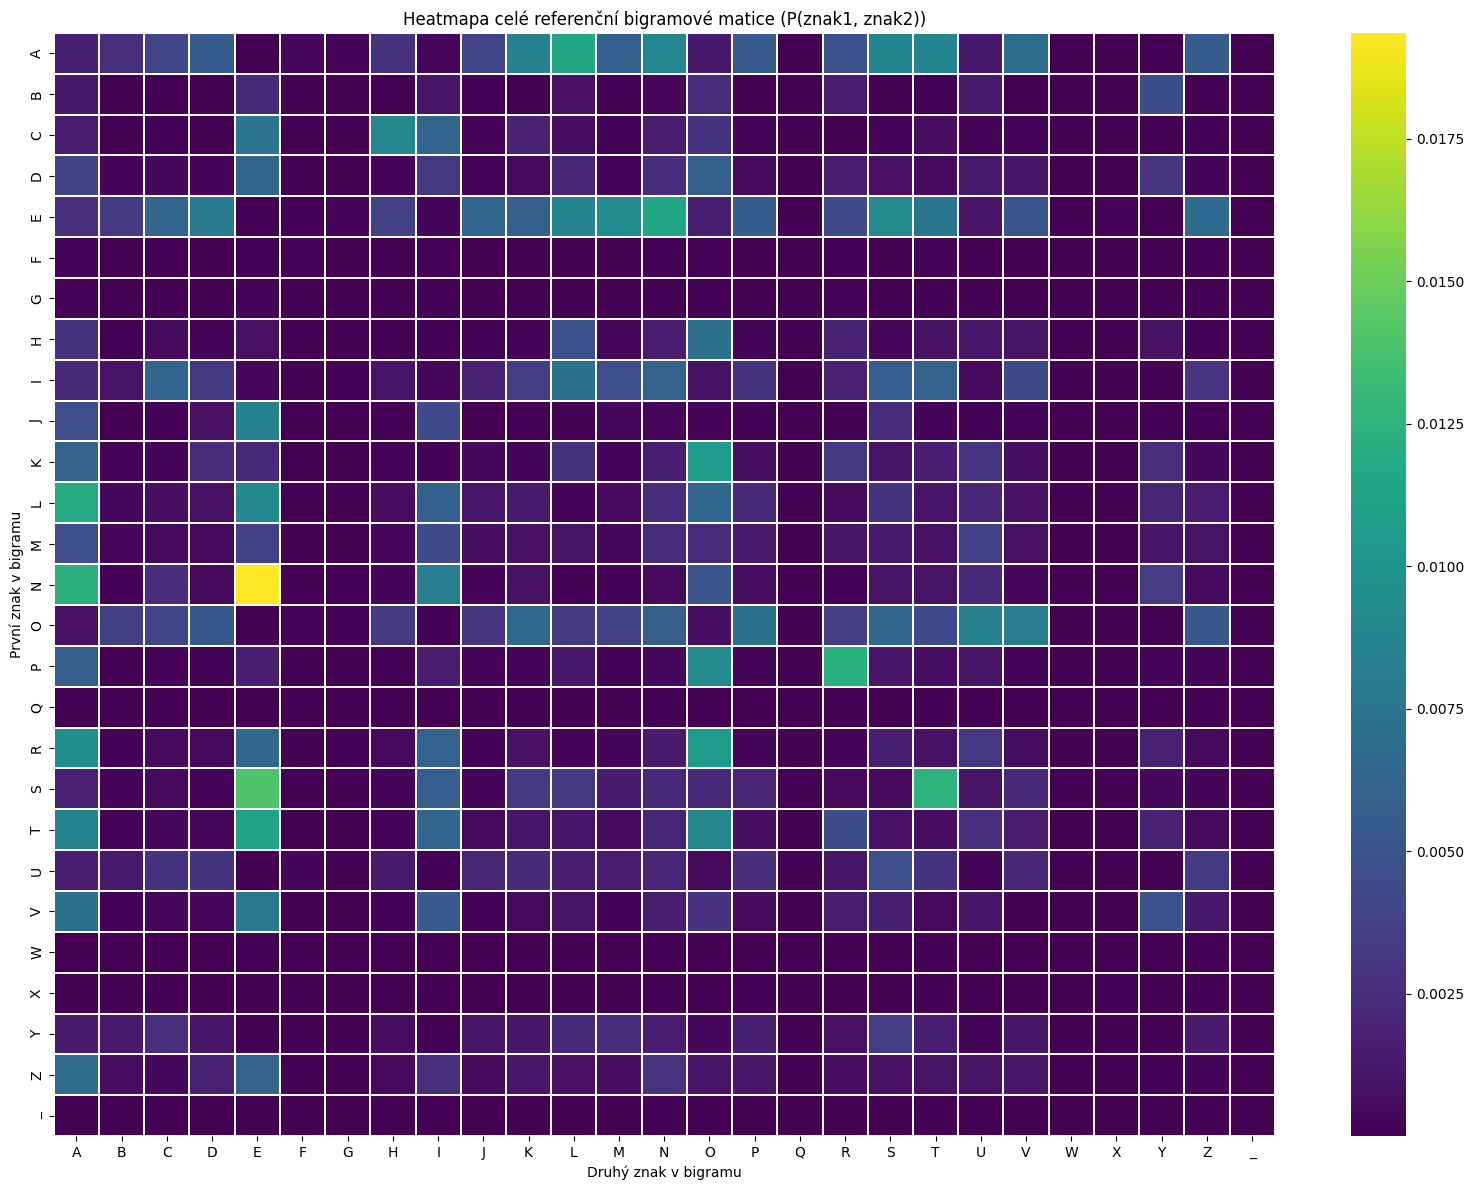

In [45]:
# Visualize the transition matrix
chars_to_plot = ['A', 'B', 'C']
indices_to_plot = [ALPHABET.find(char) for char in chars_to_plot]
subset_tm = tm_ref[indices_to_plot, :]

plt.figure(figsize=(16, 12)) 
sns.heatmap(
    tm_ref,
    xticklabels=list(ALPHABET),
    yticklabels=list(ALPHABET),
    cmap="viridis", 
    annot=False,   

    linewidths=.1
)
plt.title("Heatmapa celé referenční bigramové matice (P(znak1, znak2))")
plt.xlabel("Druhý znak v bigramu")
plt.ylabel("První znak v bigramu")
plt.tight_layout()
plt.show()